# Regresión Logística

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests

In [158]:
session = tf.Session()

In [71]:
url = "https://raw.githubusercontent.com/DGV1995/Curso-TensorFlow/master/datasets/birthweight.dat"
birth_file = requests.get(url)
birth_data = birth_file.text.split("\r\n")

In [72]:
birth_data

['LOW\tAGE\tLWT\tRACE\tSMOKE\tPTL\tHT\tUI\tBWT',
 '1\t28\t113\t1\t1\t1\t0\t1\t709',
 '1\t29\t130\t0\t0\t0\t0\t1\t1021',
 '1\t34\t187\t1\t1\t0\t1\t0\t1135',
 '1\t25\t105\t1\t0\t1\t1\t0\t1330',
 '1\t25\t85\t1\t0\t0\t0\t1\t1474',
 '1\t27\t150\t1\t0\t0\t0\t0\t1588',
 '1\t23\t97\t1\t0\t0\t0\t1\t1588',
 '1\t24\t128\t1\t0\t1\t0\t0\t1701',
 '1\t24\t132\t1\t0\t0\t1\t0\t1729',
 '1\t21\t165\t0\t1\t0\t1\t0\t1790',
 '1\t32\t105\t1\t1\t0\t0\t0\t1818',
 '1\t19\t91\t0\t1\t1\t0\t1\t1885',
 '1\t25\t115\t1\t0\t0\t0\t0\t1893',
 '1\t16\t130\t1\t0\t0\t0\t0\t1899',
 '1\t25\t92\t0\t1\t0\t0\t0\t1928',
 '1\t20\t150\t0\t1\t0\t0\t0\t1928',
 '1\t21\t190\t1\t0\t0\t0\t1\t1928',
 '1\t24\t155\t0\t1\t1\t0\t0\t1936',
 '1\t21\t103\t1\t0\t0\t0\t0\t1970',
 '1\t20\t125\t1\t0\t0\t0\t1\t2055',
 '1\t25\t89\t1\t0\t1\t0\t0\t2055',
 '1\t19\t102\t0\t0\t0\t0\t0\t2082',
 '1\t19\t112\t0\t1\t0\t0\t1\t2084',
 '1\t26\t117\t0\t1\t1\t0\t1\t2084',
 '1\t24\t138\t0\t0\t0\t0\t0\t2100',
 '1\t17\t130\t1\t1\t1\t0\t1\t2125',
 '1\t20\t120\t1\t1\t0

In [73]:
header = birth_data[0].split("\t")
data = [[float(x) for x in y.split("\t") if len(x) >= 1] for y in birth_data[1:] if len(y) >= 1]

In [74]:
import os
import csv

filename = "../../datasets/birthweight.csv"

if os.path.exists(filename):
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerows(data)
        f.close()

In [75]:
import pandas as pd

birth_data = []

with open(filename, newline="") as csvfile:
    csv_reader = csv.reader(csvfile)
    birth_header = next(csv_reader)
    for row in csv_reader:
        birth_data.append(row)

In [76]:
birth_data[0]

['1.0', '28.0', '113.0', '1.0', '1.0', '1.0', '0.0', '1.0', '709.0']

In [77]:
birth_data = [[float(x) for x in row] for row in birth_data]
birth_data[0]

[1.0, 28.0, 113.0, 1.0, 1.0, 1.0, 0.0, 1.0, 709.0]

In [78]:
y_vals = np.array([x[0] for x in birth_data])
x_vals = np.array([x[1:] for x in birth_data])

## Dividir en entrenamiento y test

In [79]:
train_idx = np.random.choice(len(x_vals), size=round(len(x_vals)*0.8), replace=False)
test_idx = np.array(list(set(range(len(x_vals))) - set(train_idx)))

x_train = x_vals[train_idx]
y_train = y_vals[train_idx]
x_test = x_vals[test_idx]
y_test = y_vals[test_idx]

## Normalización de los datos

Importante para que la regresión logística converja

In [80]:
from sklearn.preprocessing import normalize

In [81]:
def normalize_cols(column, col_min = np.array([None]), col_max = np.array([None])):
    if not col_min[0]: # Si no hemos suministrado ningún array indicando la columna mínima
        col_min = column.min(axis=0)
    if not col_max[0]:
        col_max = column.max(axis=0)
    return (column - col_min)/(col_max - col_min), col_min, col_max

# Normalizará la columna 'column' entre los valores 'col_min' y 'col_max'

In [85]:
x_train_normalized, train_min, train_max = np.nan_to_num(normalize_cols(x_train))

In [87]:
x_train_normalized[0]

array([0.64516129, 0.70833333, 1.        , 1.        , 0.        ,
       1.        , 0.        , 0.09950946])

In [84]:
train_min, train_max

(array([ 14.,  85.,   0.,   0.,   0.,   0.,   0., 709.]),
 array([4.50e+01, 2.29e+02, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
        1.00e+00, 4.99e+03]))

In [88]:
x_test_normalized = np.nan_to_num(normalize_cols(x_test, col_min=train_min, col_max=train_max))
# Se debe escalar el test con los mismos factores de escala que se hayan llevado a cabo en el entrenamiento

## Modelo de regresión logística

In [143]:
batch_size = 25
learning_rate = 0.01

In [144]:
x_vals.shape

(189, 8)

- $ x \in \mathbb R^7 $
- $ A \in \mathbb R_{8x1} $
- $ b \in \mathbb R $
- $ y = Ax + b \in R $
- $ \hat{y} = sigmoid(y) \in (0,1) $

In [159]:
x_data = tf.placeholder(shape=[None, x_vals.shape[1]], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[8,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))
y_pred = tf.add(tf.matmul(x_data, A), b)

In [160]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_target))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [161]:
init = tf.global_variables_initializer()
session.run(init)

In [162]:
classification_lr = tf.round(tf.sigmoid(y_pred)) # y^
correct_classification = tf.cast(tf.equal(classification_lr, y_target), tf.float32)
accuracy = tf.reduce_mean(correct_classification)

In [163]:
loss_vect = []
train_accuracy = []
test_accuracy = []

for i in range(2000):
    rand_idx = np.random.choice(len(x_train), size=batch_size)
    rand_x = x_train[rand_idx]
    rand_y = np.transpose([y_train[rand_idx]])
    session.run(train, feed_dict={x_data: rand_x, y_target: rand_y})
    temp_loss = session.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vect.append(temp_loss)
    acc_train = session.run(accuracy, feed_dict={x_data: x_train, y_target: np.transpose([y_train])})
    train_accuracy.append(acc_train)
    acc_test = session.run(accuracy, feed_dict={x_data: x_test, y_target: np.transpose([y_test])})
    test_accuracy.append(acc_test)
    if (i+1)%100 == 0:
        print("Step #{} ==> Train Accuracy: {}, Test Accuracy: {} Loss: {}".format(i+1, acc_train, acc_test, temp_loss))

Step #100 ==> Train Accuracy: 0.3178808093070984, Test Accuracy: 0.2368421107530594 Loss: 1.3893537521362305
Step #200 ==> Train Accuracy: 0.5364238619804382, Test Accuracy: 0.2368421107530594 Loss: 0.7926295399665833
Step #300 ==> Train Accuracy: 0.5827814340591431, Test Accuracy: 0.2368421107530594 Loss: 0.7810009717941284
Step #400 ==> Train Accuracy: 0.6225165724754333, Test Accuracy: 0.2368421107530594 Loss: 0.5610067248344421
Step #500 ==> Train Accuracy: 0.6357616186141968, Test Accuracy: 0.2368421107530594 Loss: 0.5665194988250732
Step #600 ==> Train Accuracy: 0.7218543291091919, Test Accuracy: 0.7631579041481018 Loss: 0.6567369103431702
Step #700 ==> Train Accuracy: 0.748344361782074, Test Accuracy: 0.7631579041481018 Loss: 0.5835410952568054
Step #800 ==> Train Accuracy: 0.7417218685150146, Test Accuracy: 0.7631579041481018 Loss: 0.5400846004486084
Step #900 ==> Train Accuracy: 0.7417218685150146, Test Accuracy: 0.7631579041481018 Loss: 0.6071128845214844
Step #1000 ==> Train

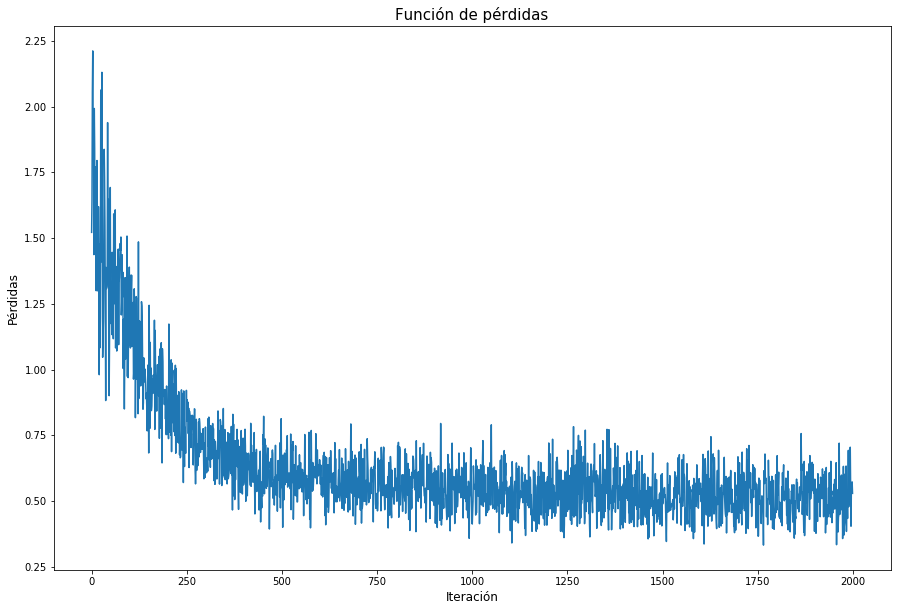

In [164]:
plt.figure(figsize=(15,10))
plt.plot(loss_vect)
plt.title("Función de pérdidas", fontsize=15)
plt.xlabel("Iteración", fontsize=12)
plt.ylabel("Pérdidas", fontsize=12)
plt.show()

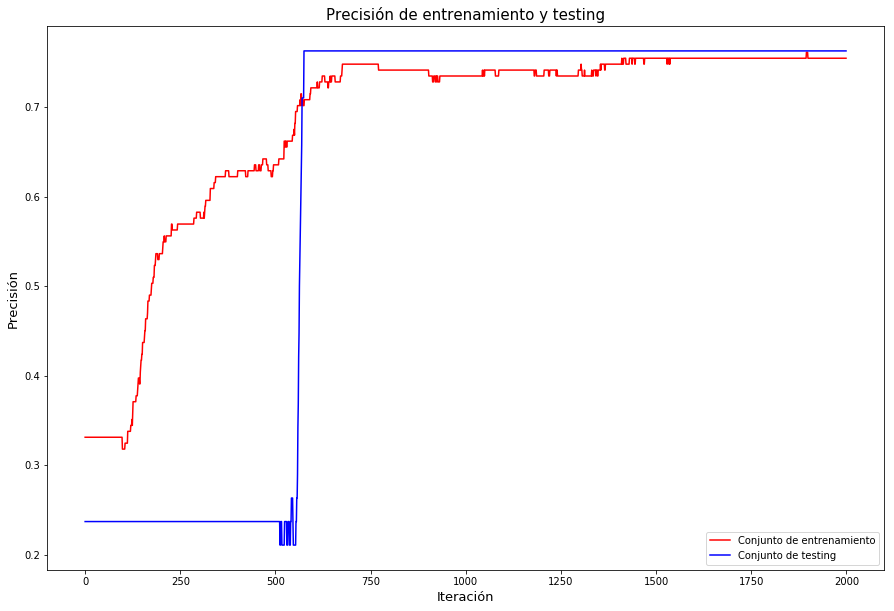

In [167]:
plt.figure(figsize=(15,10))
plt.plot(train_accuracy, "r", label="Conjunto de entrenamiento")
plt.plot(test_accuracy, "b", label="Conjunto de testing")
plt.title("Precisión de entrenamiento y testing", fontsize=15)
plt.xlabel("Iteración", fontsize=13)
plt.ylabel("Precisión", fontsize=13)
plt.legend(loc="lower right")
plt.show()